# Лабораторная работа №1
## Исследование метрик и характеристик систем биометрической аутентификации на основе принципов ROC-анализа
### Вариант №1
#### "Свой": Треугольное распределение
#### "Чужой": Треугольное распределение

In [52]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import triang

warnings.simplefilter(action='ignore', category=FutureWarning)

<p align="center">
  <h2>Треугольное распределение образов</h2>
  <img src="img/Triangular_distribution_PMF.png" weight="400" height="600" alt="img_3">
</p>

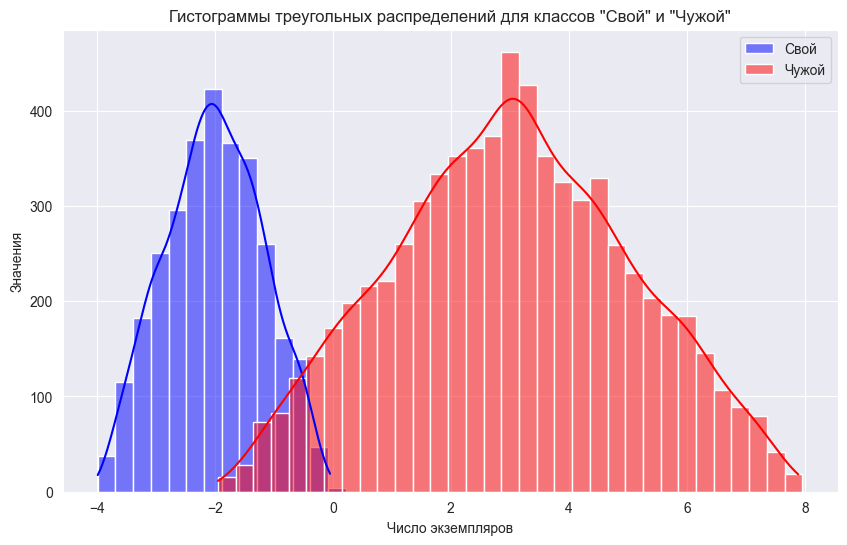

In [53]:
# Параметры для первого треугольного распределения (класс "Свой").
a1, c1, b1 = -4, -2, 0
# Параметры для второго треугольного распределения (класс "Чужой").
a2, c2, b2 = -2, 3, 8

# Количество выборок и размер каждой выборки
num_samples_own: int = 3000
num_samples_foreign: int = 7000

# Генерируем выборки для классов "Свой" и "Чужой"
samples_own: np.ndarray = triang.rvs(
    (c1 - a1) / (b1 - a1),
    loc=a1,
    scale=b1 - a1,
    size=(num_samples_own, 1),
)
samples_foreign: np.ndarray = triang.rvs(
    (c2 - a2) / (b2 - a2),
    loc=a2,
    scale=b2 - a2,
    size=(num_samples_foreign, 1),
)

# Гистограммы распределений.
plt.figure(figsize=(10, 6))
BINWIDTH = 0.3
sns.histplot(samples_own.flatten(), kde=True, label='Свой', color='blue', binwidth=BINWIDTH)
sns.histplot(samples_foreign.flatten(), kde=True, label='Чужой', color='red', binwidth=BINWIDTH)

plt.xlabel('Число экземпляров')
plt.ylabel('Значения')
plt.legend(loc='best')
plt.title('Гистограммы треугольных распределений для классов "Свой" и "Чужой"')
plt.grid(True)

## Установка порогов

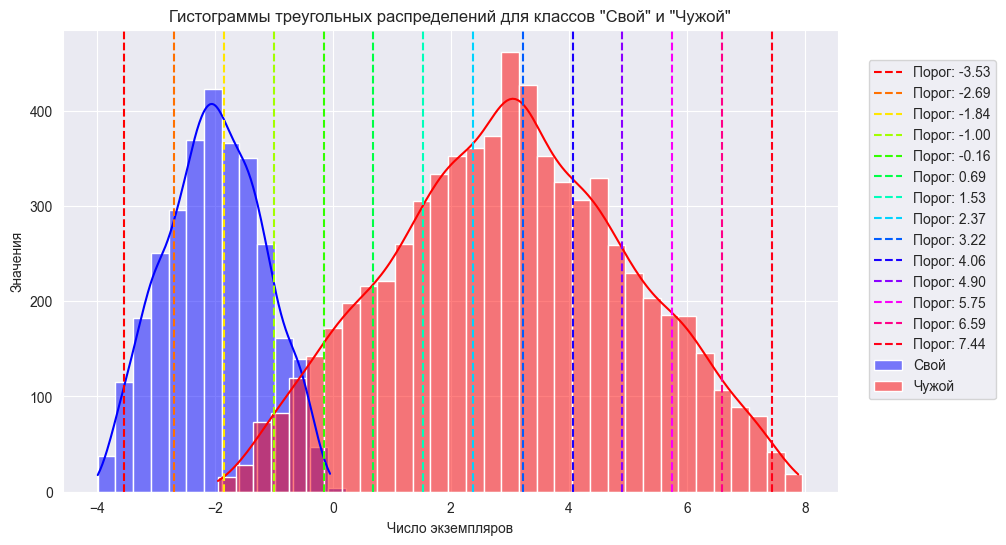

In [54]:
delta = 0.45
threshold_num = 14
thresholds = np.linspace(
    start=np.min(samples_own) + delta,
    stop=np.max(samples_foreign) - delta,
    num=threshold_num,
)

# Гистограммы распределений.
plt.figure(figsize=(10, 6))
BINWIDTH = 0.3
sns.histplot(samples_own.flatten(), kde=True, label='Свой', color='blue', binwidth=BINWIDTH)
sns.histplot(samples_foreign.flatten(), kde=True, label='Чужой', color='red', binwidth=BINWIDTH)

threshold_colors = [plt.get_cmap('hsv')(i) for i in np.linspace(0, 1, len(thresholds))]
for i, threshold in enumerate(thresholds):
    plt.axvline(
        x=threshold, color=threshold_colors[i],
        linestyle='--', label=f'Порог: {threshold:.2f}',
    )

plt.xlabel('Число экземпляров')
plt.ylabel('Значения')
plt.legend(loc=(1.04, 0.2))
plt.title('Гистограммы треугольных распределений для классов "Свой" и "Чужой"')
plt.grid(True)

In [55]:
from sklearn import metrics
from prettytable import PrettyTable

own, foreign = samples_own.flatten(), samples_foreign.flatten()
own.sort()
foreign.sort()

tpr_list = []
fpr_list = []
confusion_matrix_tables = []
for threshold in thresholds:
    # Выполним бинарную классификацию на основе порога
    predictions_own = (own < threshold).astype(int)
    predictions_foreign = (foreign < threshold).astype(int)

    y_actual = np.concatenate([np.ones(num_samples_own), np.zeros(num_samples_foreign)])
    y_pred = np.concatenate([predictions_own, predictions_foreign])
    # Вычислим матрицу ошибок для текущего порога
    tn, fp, fn, tp = metrics.confusion_matrix(y_actual, y_pred).ravel()

    confusion_matrix_table = PrettyTable(
        field_names=(f'Порог: {threshold:.2f}', 'Actual "Свой" (1)', 'Actual "Чужой" (0)'),
    )
    confusion_matrix_table.add_rows((
        ('Predicted "Свой" (1)', f'TP = {tp}', f'FP = {fp}'),
        ('Predicted "Чужой" (0)', f'FN = {fn}', f'TN = {tn}'),
    ))

    print(confusion_matrix_table)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    print(f'TPR = {tpr:.4f}; FPR = {fpr:.4f}')
    tpr_list.append(tpr)
    fpr_list.append(fpr)

+-----------------------+-------------------+--------------------+
|      Порог: -3.53     | Actual "Свой" (1) | Actual "Чужой" (0) |
+-----------------------+-------------------+--------------------+
|  Predicted "Свой" (1) |      TP = 89      |       FP = 0       |
| Predicted "Чужой" (0) |     FN = 2911     |     TN = 7000      |
+-----------------------+-------------------+--------------------+
TPR = 0.0297; FPR = 0.0000
+-----------------------+-------------------+--------------------+
|      Порог: -2.69     | Actual "Свой" (1) | Actual "Чужой" (0) |
+-----------------------+-------------------+--------------------+
|  Predicted "Свой" (1) |      TP = 655     |       FP = 0       |
| Predicted "Чужой" (0) |     FN = 2345     |     TN = 7000      |
+-----------------------+-------------------+--------------------+
TPR = 0.2183; FPR = 0.0000
+-----------------------+-------------------+--------------------+
|      Порог: -1.84     | Actual "Свой" (1) | Actual "Чужой" (0) |
+-------

AUC = 0.9851175952380952


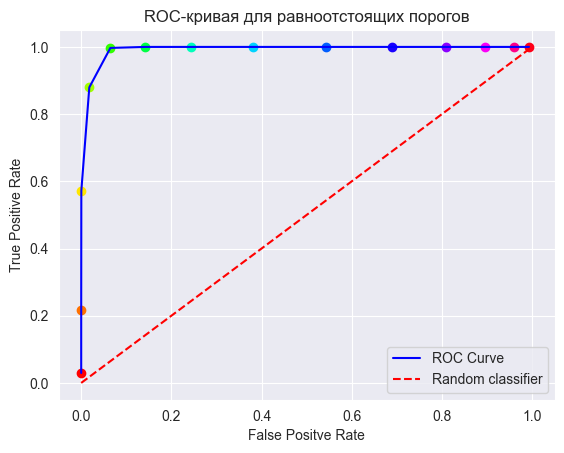

In [57]:
from sklearn import metrics

for i, _ in enumerate(thresholds):
    plt.plot(
        [fpr_list[i]], [tpr_list[i]], 'o',
        color=threshold_colors[i],
        
    )

plt.plot(fpr_list, tpr_list, label="ROC Curve", color="blue")
plt.title('ROC-кривая для равноотстоящих порогов')
plt.xlabel("False Positve Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random classifier')
plt.legend()
print(f'AUC = {metrics.auc(fpr_list, tpr_list)}')